In [1]:
!mkdir ~/.kaggle

In [2]:
!mkdir .kaggle

In [3]:
import json
token = {"username":"ee17b046","key":"8ebf0dfa9a52e9c4bb4d6004aa33f6d9"}
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)

In [4]:
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json

In [5]:
!chmod 600 /root/.kaggle/kaggle.json

In [6]:
!kaggle datasets download -d splcher/animefacedataset

 98% 385M/395M [00:10<00:00, 34.7MB/s]
100% 395M/395M [00:10<00:00, 39.9MB/s]


In [7]:
!unzip /content/animefacedataset.zip -d /content/animefacedataset

Streaming output truncated to the last 5000 lines.
  inflating: /content/animefacedataset/images/62765_2019.jpg  
  inflating: /content/animefacedataset/images/62766_2019.jpg  
  inflating: /content/animefacedataset/images/62767_2019.jpg  
  inflating: /content/animefacedataset/images/62768_2019.jpg  
  inflating: /content/animefacedataset/images/62769_2019.jpg  
  inflating: /content/animefacedataset/images/6276_2003.jpg  
  inflating: /content/animefacedataset/images/62770_2019.jpg  
  inflating: /content/animefacedataset/images/62771_2019.jpg  
  inflating: /content/animefacedataset/images/62772_2019.jpg  
  inflating: /content/animefacedataset/images/62773_2019.jpg  
  inflating: /content/animefacedataset/images/62774_2019.jpg  
  inflating: /content/animefacedataset/images/62775_2019.jpg  
  inflating: /content/animefacedataset/images/62776_2019.jpg  
  inflating: /content/animefacedataset/images/62777_2019.jpg  
  inflating: /content/animefacedataset/images/62778_2019.jpg  
  inf

In [8]:
DATA_DIR = "/content/animefacedataset/"

In [9]:
import os
os.listdir(DATA_DIR)

['images']

In [10]:
os.listdir(DATA_DIR + '/images')[:10]

['57465_2017.jpg',
 '19372_2007.jpg',
 '19770_2007.jpg',
 '20168_2007.jpg',
 '2419_2001.jpg',
 '40698_2013.jpg',
 '4422_2003.jpg',
 '23533_2008.jpg',
 '51980_2015.jpg',
 '22496_2008.jpg']

In [11]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T

In [12]:
image_size = 64
batch_size = 128
stats = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [13]:
train_ds = ImageFolder(DATA_DIR, transform = T.Compose([
                        T.Resize(image_size),
                        T.CenterCrop(image_size),
                        T.ToTensor(),
                        T.Normalize(*stats)]))

train_dl = DataLoader(train_ds, batch_size, shuffle=True, num_workers=3, pin_memory=True)

In [14]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [16]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1,2, 0))
    
def show_batch(dl ,nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break


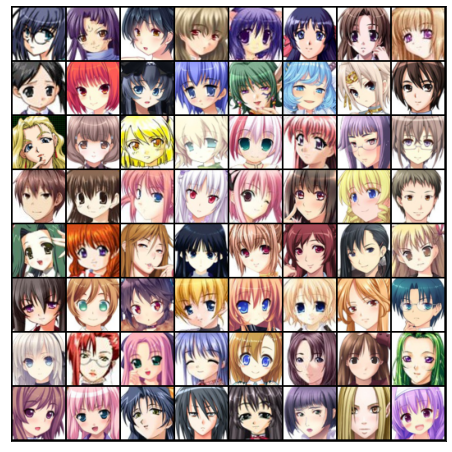

In [17]:
show_batch(train_dl)

In [18]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)


In [19]:
device = get_default_device()
device

device(type='cpu')

In [20]:
train_dl = DeviceDataLoader(train_dl , device)

In [21]:
import torch.nn as nn

In [22]:
discriminator = nn.Sequential(
    # in: 3 x 64 x 64
    
    nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2, inplace=True),
    # out: 64 x 32 x 32

    nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 128 x 16 x 16
    
    nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 256 x 8 x 8
    
    nn.Conv2d(256, 512, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2, inplace=True),
    #out: 512 x 4 x 4
    
    nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=0, bias=False),
    #out: 1 x 1 x 1
    
    nn.Flatten(),
    nn.Sigmoid())

In [23]:
discriminator = to_device(discriminator, device)

In [24]:
latent_size = 128

In [25]:
generator = nn.Sequential(
    # in: latent_size x 1 x 1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),
    # out: 512 x 4 x 4
    
    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    # out: 256 x 8 x 8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128 x 16 x 16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64 x 32 x 32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()
    #out: 3 x 64 x 64
)


torch.Size([128, 3, 64, 64])


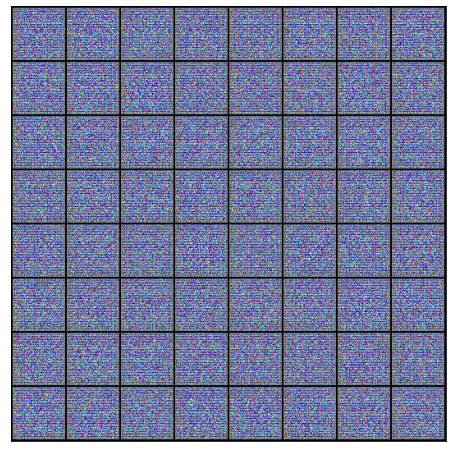

In [26]:
# Let's generate some outputs using the generator and view them as images by transforming and denormalizing the output.

xb = torch.randn(batch_size, latent_size, 1, 1)
fake_images = generator(xb)
print(fake_images.shape)
show_images(fake_images)

In [27]:
generator = to_device(generator, device)

In [28]:
def train_discriminator(real_images, opt_d):
    #clear discriminator gradients
    opt_d.zero_grad()
    
    #pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()
    
    #generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()
    
    #update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score


In [29]:
def gradient_loss(gen_frames, alpha=2):

    def gradient(x):
        # idea from tf.image.image_gradients(image)
        # https://github.com/tensorflow/tensorflow/blob/r2.1/tensorflow/python/ops/image_ops_impl.py#L3441-L3512
        # x: (b,c,h,w), float32 or float64
        # dx, dy: (b,c,h,w)

        h_x = x.size()[-2]
        w_x = x.size()[-1]
        # gradient step=1
        left = x
        right = F.pad(x, [0, 1, 0, 0])[:, :, :, 1:]
        top = x
        bottom = F.pad(x, [0, 0, 0, 1])[:, :, 1:, :]

        # dx, dy = torch.abs(right - left), torch.abs(bottom - top)
        dx, dy = right - left, bottom - top 
        # dx will always have zeros in the last column, right-left
        # dy will always have zeros in the last row,    bottom-top
        dx[:, :, :, -1] = 0
        dy[:, :, -1, :] = 0

        return dx, dy

    # gradient
    gen_dx, gen_dy = gradient(gen_frames)
    
    # condense into one tensor and avg
    return torch.mean(gen_dx ** alpha + gen_dy ** alpha)

In [30]:
lambda1 = 0.01

In [31]:
def train_generator(opt_g):
    #clear generator gradients
    opt_g.zero_grad()
    
    #generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)
    
    #Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)

    loss = F.binary_cross_entropy(preds, targets) + lambda1*gradient_loss(fake_images)
    #print(F.binary_cross_entropy(preds, targets),gradient_loss(fake_images))
    #update generator weights
    loss.backward()
    opt_g.step()
    
    return loss.item()


In [32]:
from torchvision.utils import save_image

In [33]:
sample_dir = 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [34]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(denorm(fake_images).cpu().detach(), nrow=8).permute(1, 2, 0))
        plt.show()


In [35]:
fixed_latent = torch.randn(64, latent_size, 1, 1, device=device)

Saving generated-images-0000.png


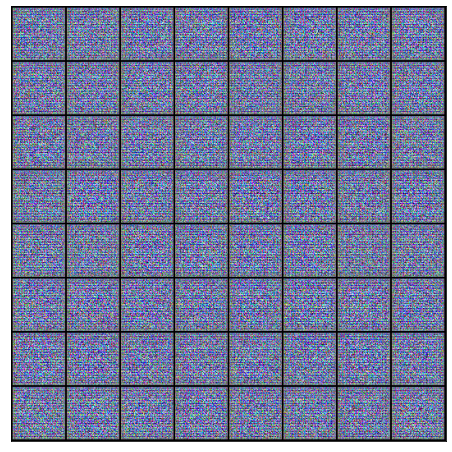

In [36]:
save_samples(0, fixed_latent)

In [37]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [38]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [40]:
#torch.save(generator.state_dict(), '/content/gdrive/My Drive/G.pt')
#torch.save(discriminator.state_dict(),'/content/gdrive/My Drive/D.pt')
generator.load_state_dict(torch.load('/content/gdrive/My Drive/G.pt',map_location = torch.device('cpu')))
discriminator.load_state_dict(torch.load('/content/gdrive/My Drive/D.pt',map_location = torch.device('cpu')))



<All keys matched successfully>

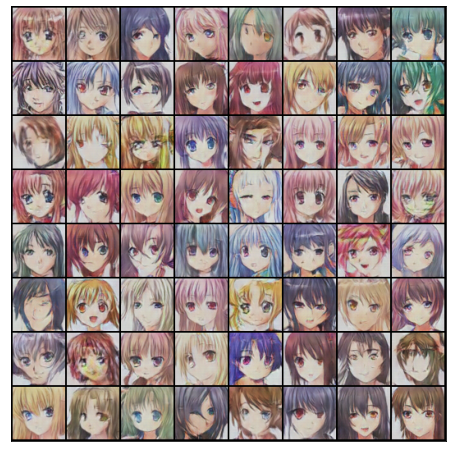

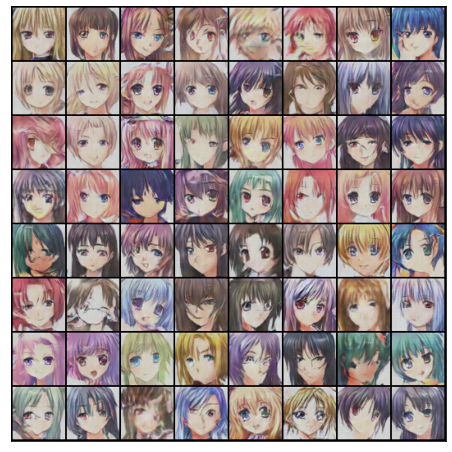

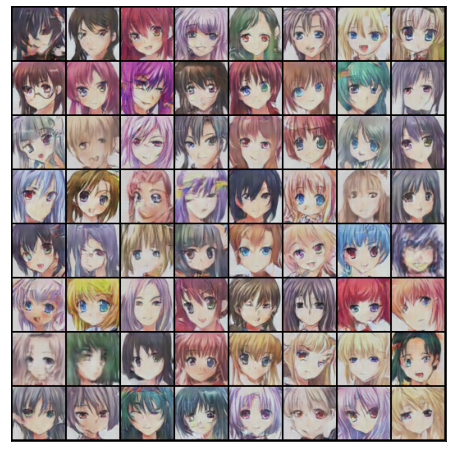

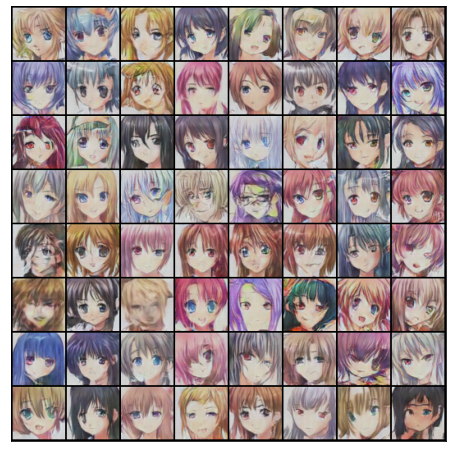

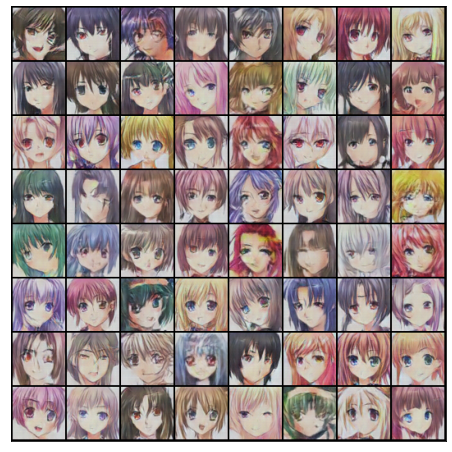

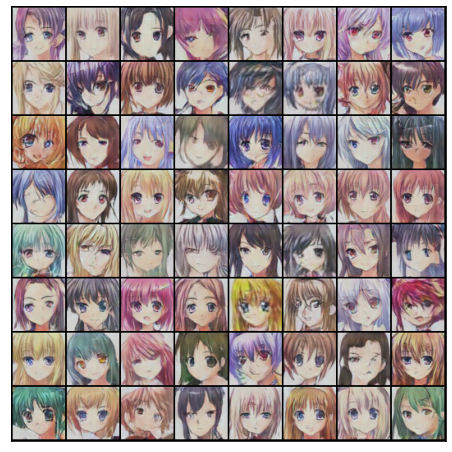

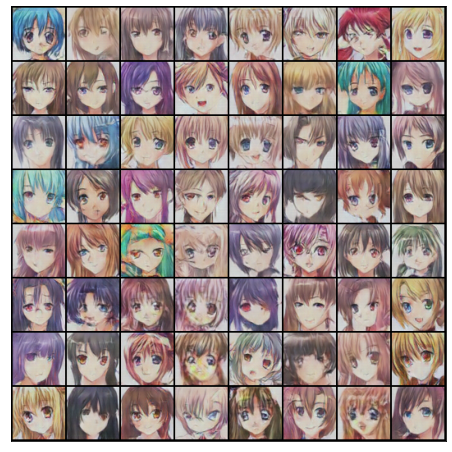

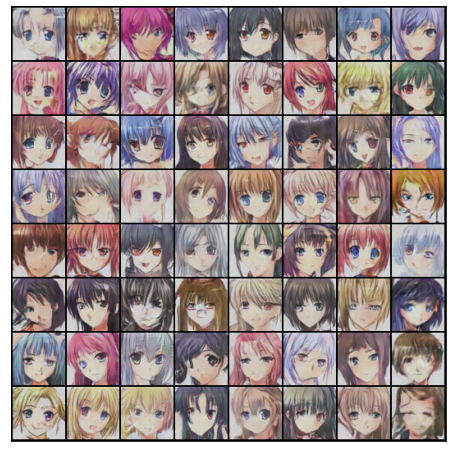

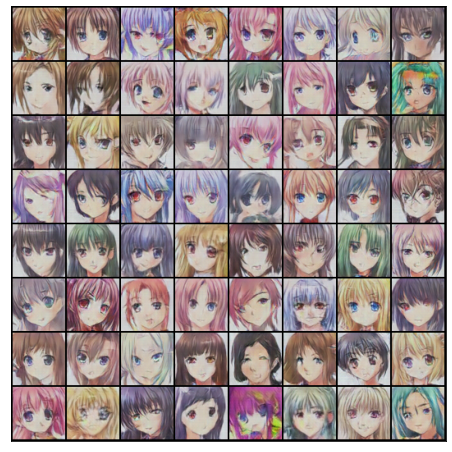

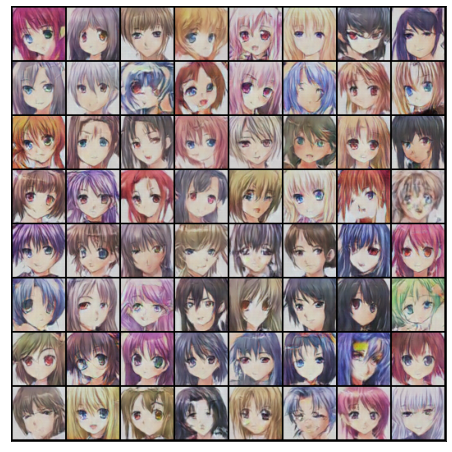

In [43]:
##this will show result of the training
for i in range(10):
  print('{i}th image :'.format(i =i))
  show_images(generator(torch.randn(batch_size, latent_size, 1, 1)))

In [41]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()
    
    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))
    
    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)
            
        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)
        
        # Log losses & scores
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
                epoch+1, epochs, loss_g, loss_d, real_score, fake_score))
        
        # Save generated images
        save_samples(epoch+start_idx, fixed_latent)
        torch.save(generator.state_dict(), '/content/gdrive/My Drive/G.pt')
        torch.save(discriminator.state_dict(),'/content/gdrive/My Drive/D.pt')
    return losses_g, losses_d, real_scores, fake_scores

In [42]:
lr = 0.0002
epochs = 25


Epoch [1/25], loss_g: 4.6636, loss_d: 0.4387, real_score: 0.9401, fake_score: 0.2487
Saving generated-images-0001.png


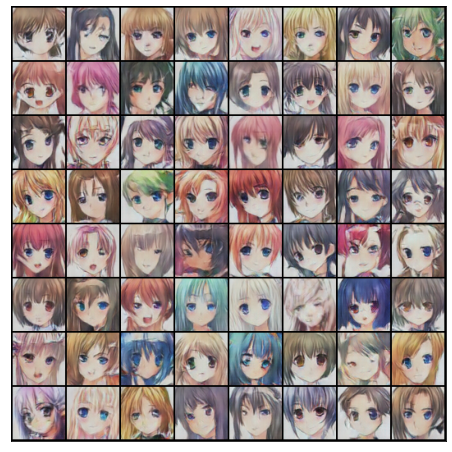


Epoch [2/25], loss_g: 2.9852, loss_d: 0.1486, real_score: 0.8768, fake_score: 0.0054
Saving generated-images-0002.png


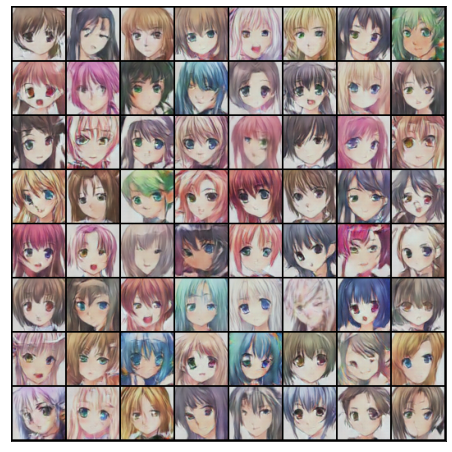


Epoch [3/25], loss_g: 5.0227, loss_d: 0.2220, real_score: 0.9523, fake_score: 0.1332
Saving generated-images-0003.png


In [ ]:
history = fit(epochs, lr)

In [ ]:
losses_g, losses_d, real_scores, fake_scores = history

In [ ]:
torch.save(generator.state_dict(), 'G.ckpt')
torch.save(discriminator.state_dict(), 'D.ckpt')

In [ ]:
from IPython.display import Image

In [ ]:
Image('./generated/generated-images-0001.png')